<a href="https://colab.research.google.com/github/jitbnerejee4/jit/blob/fastai/Copy_of_msivanes_lesson3_planet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [0]:
import jovian

<IPython.core.display.Javascript object>

In [0]:
#!pip install jovian

  Running setup.py bdist_wheel for jovian ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/67/9f/b0/b841f81da3f8c9919ed232fa14bba397c5c38fa8df5d125d8a
  Running setup.py bdist_wheel for uuid ... done
  Stored in directory: /home/ubuntu/.cache/pip/wheels/2a/80/9b/015026567c29fdffe31d91edbe7ba1b17728db79194fca1f21
Successfully built jovian uuid
fastai 1.0.54 requires nvidia-ml-py3, which is not installed.
thinc 6.12.1 has requirement msgpack<0.6.0,>=0.5.6, but you'll have msgpack 0.6.0 which is incompatible.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Fetch the data

In [0]:
#! {sys.executable} -m pip install kaggle --upgrade

In [0]:
#! mkdir -p ~/.kaggle
#! mv kaggle.json ~/.kaggle

In [0]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

# Load the data

In [3]:
#planet_tiny = untar_data(URLs.PLANET_TINY)
planet = untar_data(URLs.PLANET_SAMPLE)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [4]:
planet.ls()

[PosixPath('/root/.fastai/data/planet_sample/labels.csv'),
 PosixPath('/root/.fastai/data/planet_sample/train')]

In [5]:
df = pd.read_csv(planet/'labels.csv');df.head()

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road


In [6]:
len(df)

1000

In [0]:
np.random.seed(42)
#Creating a databunch using Factory method approach
#data = (ImageDataBunch.from_csv(planet_tiny, folder='train', size=128, 
#                         suffix='jpg', label_delim=' ', ds_tfms=planet_tiny_tfms))
# #### Above is not working #####                        

#Datablock api
#
source = (ImageList.from_df(df, path=planet, folder='train', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

# Databunch

In [0]:
data = (source.transform(planet_tfms, size = 128) #Reduce the size if needed
       .databunch().normalize(imagenet_stats))

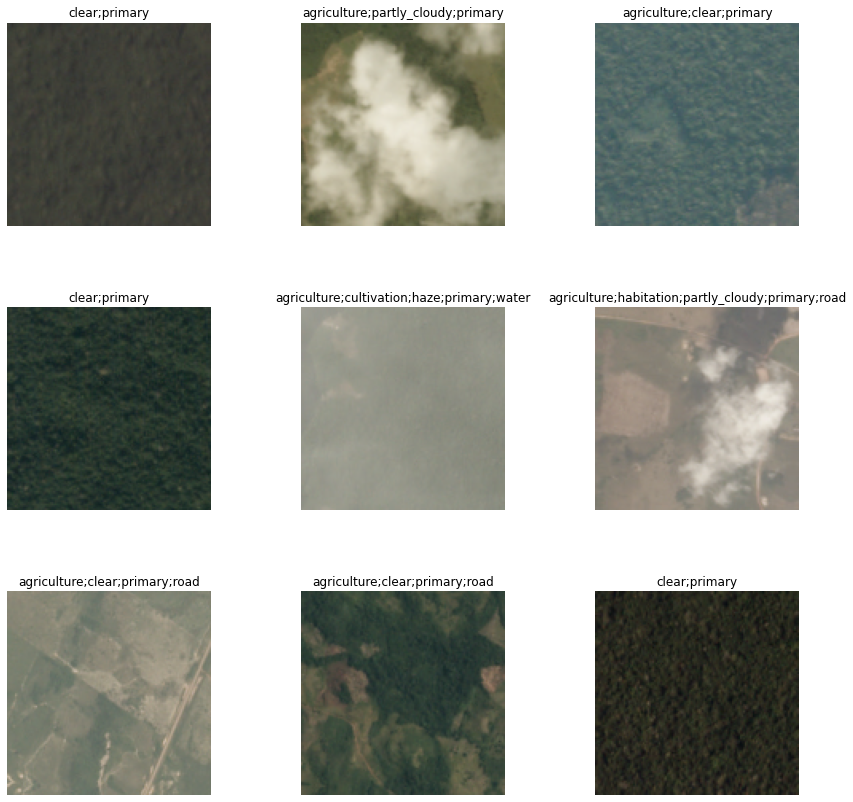

In [9]:
data.show_batch(rows=3, figsize=(12,12))

Create the `Learner` same as before. base arch is resnet50 but the metrics used is going to `accuracy_thresh` (vs `accuracy`)

# Training the model

In [0]:
arch = models.resnet50

In [0]:
#doc(cnn_learner)

In [0]:
# Do not understand the below 2 lines
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)


In [12]:
learner = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


# Find the learning rate

Using the LR Finder to pick the learning rate

In [13]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


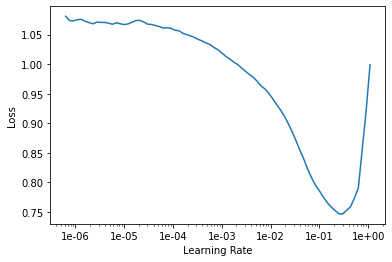

In [14]:
learner.recorder.plot()

In [0]:
lr = 0.01

In [0]:
#doc(learner.fit_one_cycle)

In [17]:
learner.fit_one_cycle(cyc_len=5, max_lr=slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.917470,0.772816,0.415938,0.542397,00:04
1,0.715247,0.313997,0.727813,0.715407,00:03
2,0.511304,0.160035,0.935000,0.867595,00:03
3,0.390126,0.150467,0.933750,0.865011,00:03
4,0.319525,0.149414,0.931875,0.862974,00:03


Always save the model once you perform fit_one_cycle.

In [0]:
learner.save('stage-1-rn50')

# Fine tuning

Train the entire model by unfreezing the whole thing.

In [0]:
learner.unfreeze()

In [20]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


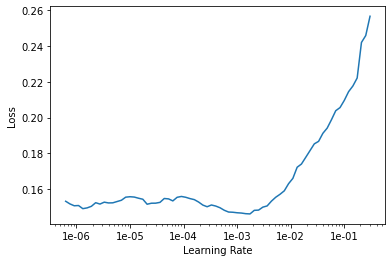

In [21]:
learner.recorder.plot()

In [22]:
learner.fit_one_cycle(cyc_len=5, max_lr=slice(1e-4, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.153070,0.149541,0.925937,0.876970,00:03
1,0.154185,0.248044,0.930313,0.840201,00:04
2,0.146041,0.165135,0.937187,0.872804,00:04
3,0.134672,0.140247,0.942187,0.880209,00:04
4,0.125012,0.135816,0.942813,0.882124,00:03


In [0]:
learner.save('stage-2-rn50')

Now increase the size of the image.

# Increased image size

In [0]:
data = (source.transform(tfms=planet_tfms, size=256)
        .databunch()
        .normalize(imagenet_stats))

In [26]:
learner.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

Freeze up to the last layer group.

In [0]:
learner.freeze()

In [29]:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256

In [30]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


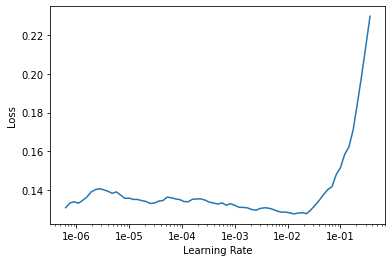

In [31]:
learner.recorder.plot()

In [0]:
lr = 1e-2/2

In [33]:
learner.fit_one_cycle(5, max_lr=slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.130149,0.132988,0.943438,0.881352,00:07
1,0.132286,0.141738,0.942500,0.879164,00:07
2,0.129640,0.140267,0.941250,0.883882,00:07
3,0.120930,0.130191,0.943750,0.883323,00:07
4,0.112351,0.130029,0.944375,0.884239,00:07


In [0]:
learner.save('stage1-256-rn50')

In [35]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


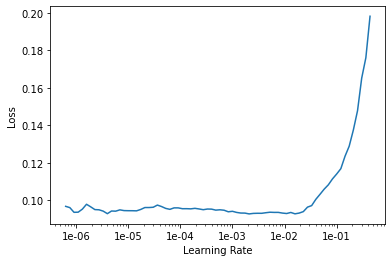

In [36]:
learner.recorder.plot()

In [0]:
learner.unfreeze()

In [38]:
learner.fit_one_cycle(5, max_lr=slice(1e-05, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.092893,0.126828,0.945312,0.890389,00:08
1,0.091103,0.132363,0.943438,0.892371,00:07
2,0.089860,0.131098,0.950938,0.886845,00:07
3,0.084709,0.128531,0.948125,0.891693,00:08
4,0.080800,0.128054,0.946875,0.891120,00:07


In [0]:
learner.save('stage2-256-rn50')

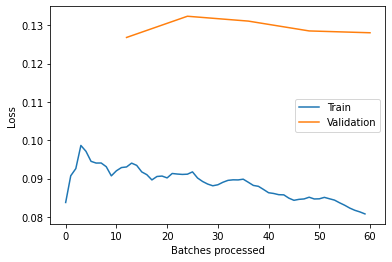

In [41]:
learner.recorder.plot_losses()